In [1]:
!pip install opencv-python

Estimated number of screws: 97.0


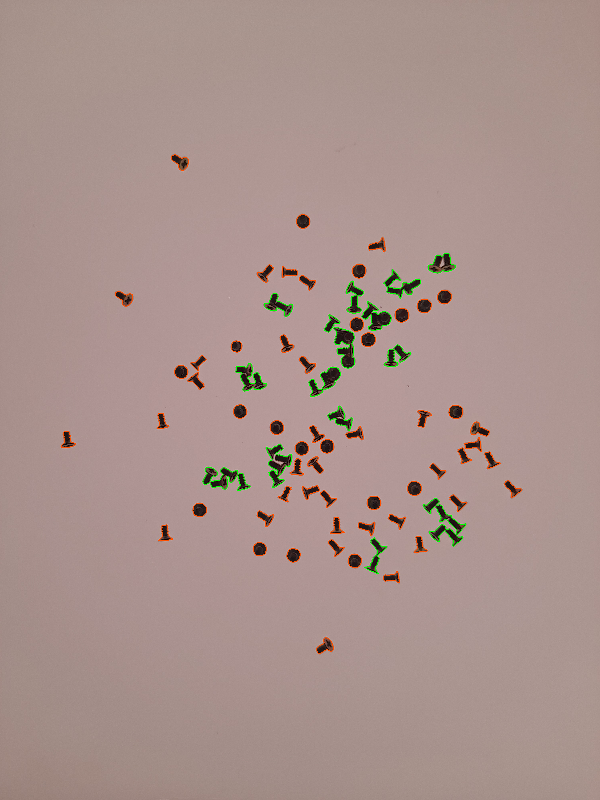

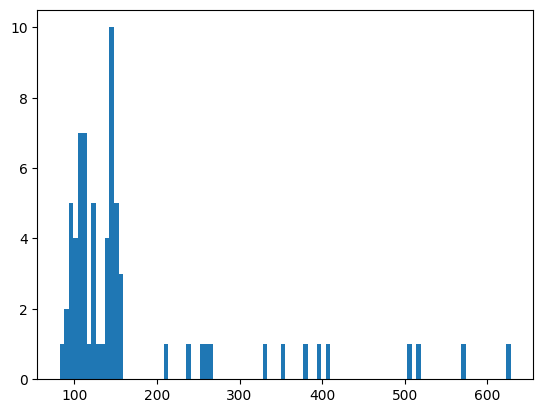

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


def resize_aspect_ratio(img, height = None):
    original_height, original_width = img.shape[:2]
    aspect_ratio = original_width / original_height
    new_width = int(height * aspect_ratio)
    return cv2.resize(img, (new_width, height))

if __name__ == "__main__":

    # Parameters set looking at the histogram below, this is brittle
    min_screw_area = 30
    max_screw_area = 200
    overlap_coef = 1.05 # Blobs of screw looses area because of overlaping, this correct that a little

    img = cv2.imread("/content/20240713_194232.jpg")
    img = resize_aspect_ratio(img, 800) # resize image for display + lets not use such a big image for now
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.bitwise_not(thresh) # inverse the image so that objects of interest are white

    # Find the contours and remove small ones (noise)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(filter(lambda cnt: cv2.contourArea(cnt) > min_screw_area, contours))

    # Compute contours area and assuming most of the screws are separated compute typical size of a screw
    areas = [cv2.contourArea(cnt) for cnt in contours]
    median_area_screw = np.median(areas)

    # Number of screws = individual screws + multiple_screw_areas / typical size of a screw
    multiple_screw_areas = list(filter(lambda area: area > max_screw_area, areas))
    num_screws = sum([np.round(area*overlap_coef/median_area_screw ) for area in multiple_screw_areas])
    num_screws += len(areas) - len(multiple_screw_areas)

    print(f"Estimated number of screws: {num_screws}")

    # Display some info for experimentation
    for cnt in contours:
        if cv2.contourArea(cnt) > max_screw_area:
            cv2.drawContours(img, [cnt], -1, (0, 255, 0), 1)
        else:
            cv2.drawContours(img, [cnt], -1, (0, 80, 255), 1)
    cv2_imshow(img)
    plt.hist(areas, bins=100)
    plt.show()
    cv2.waitKey(0)
    cv2.destroyAllWindows()

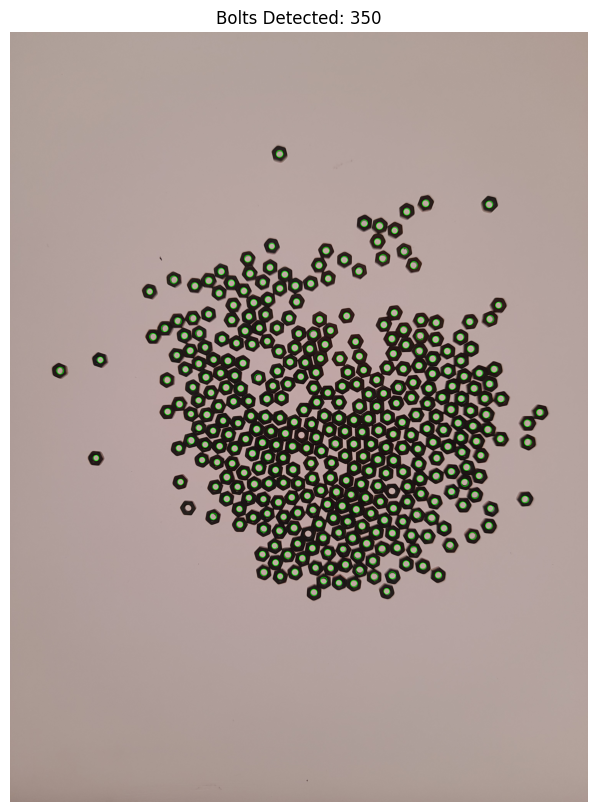

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/20240713_194541.jpg"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocessing
gray_blurred = cv2.medianBlur(gray, 5)

# Hough Circle detection (tuned for bolt-like rings)
circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=40,
    param1=50,
    param2=40,
    minRadius=8,
    maxRadius=20
)

# Draw detected circles
output_img = img.copy()
bolt_count = 0
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        x, y, r = circle
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)
        bolt_count += 1

# Display result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f"Bolts Detected: {bolt_count}")
plt.axis("off")
plt.show()
